In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from itertools import combinations

# Prepare data

In [2]:
hdf_path = '../derived_data/source.hdf'

In [3]:
%%time
train = pd.read_hdf(hdf_path, key='train')

CPU times: user 281 ms, sys: 7.75 s, total: 8.03 s
Wall time: 31.6 s


In [4]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [5]:
train.set_index('click_time', inplace=True)

In [6]:
gc.collect()

0

In [11]:
train = train.loc['2017-11-07 00:00:00':'2017-11-09 00:00:00'].copy()

In [13]:
gc.collect()

80

In [14]:
train.head()

,ip,app,device,os,channel,is_attributed
click_time,,,,,,
2017-11-07,70712,2,1,32,237,0
2017-11-07,45892,3,1,25,424,0
2017-11-07,37774,8,2,13,145,0
2017-11-07,41179,2,1,13,122,0
2017-11-07,83111,15,1,8,245,0


In [15]:
uint8_max = np.iinfo(np.uint8).max
uint16_max = np.iinfo(np.uint16).max
uint32_max = np.iinfo(np.uint32).max
def choose_int_type(n):
    if n <= uint8_max:
        return 'uint8'
    elif n <= uint16_max:
        return 'uint16'
    elif n <= uint32_max:
        return 'uint32'
    else:
        return 'uint64'

In [34]:
def rolling_count(df, time_win='1h'):
    return df.groupby(level=0, sort=False).size().rolling(time_win).sum()

In [32]:
gc.collect()

4629056

In [33]:
%%time
test = train.loc['2017-11-08 20:00:00':].groupby(['ip']).apply(rolling_count)

CPU times: user 51.3 s, sys: 419 ms, total: 51.7 s
Wall time: 50.5 s


In [35]:
%%time
test = train.loc['2017-11-08 20:00:00':].groupby(['ip'], sort=False).apply(rolling_count)

CPU times: user 50.1 s, sys: 404 ms, total: 50.5 s
Wall time: 49.4 s


In [56]:
gc.collect()

248217

In [53]:
def process(df, features, time_win='1h'):
    res = df.reset_index()
    for feature in features:
        print('Processing {feature}'.format(feature=feature))
        if isinstance(feature, str):
            feature = [feature]
        elif isinstance(feature, list):
            pass
        else:
            print('Skip invalid feature!')
            continue
        tmp = df.groupby(feature, sort=False).apply(rolling_count, time_win=time_win)
        tmp = tmp.astype(choose_int_type(tmp.max()))
        tmp.name = 'n_' + '_'.join(feature)
        tmp = tmp.reset_index()
        res = res.merge(tmp, on=['click_time']+feature, how='left')
        del tmp
        gc.collect()
    return res

In [57]:
%%time
train = process(train, ['ip', 'app', 'channel'])

Processing ip
Processing app
Processing channel
CPU times: user 5min 56s, sys: 45.9 s, total: 6min 42s
Wall time: 7min 23s


In [58]:
gc.collect()

0

In [59]:
train.head()

,click_time,ip,app,device,os,channel,is_attributed,n_ip,n_app,n_channel
0,2017-11-07,70712,2,1,32,237,0,1,84,5
1,2017-11-07,45892,3,1,25,424,0,1,96,6
2,2017-11-07,37774,8,2,13,145,0,2,41,41
3,2017-11-07,41179,2,1,13,122,0,1,84,15
4,2017-11-07,83111,15,1,8,245,0,1,91,33


In [60]:
gc.collect()

0

In [64]:
valid = train.loc[train.click_time >= '2017-11-08 00:00:00'].copy()
train = train.loc[train.click_time <= '2017-11-07 23:59:59'].copy()

In [65]:
gc.collect()

551

In [71]:
train.head()

,click_time,ip,app,device,os,channel,is_attributed,n_ip,n_app,n_channel
0,2017-11-07,70712,2,1,32,237,0,1,84,5
1,2017-11-07,45892,3,1,25,424,0,1,96,6
2,2017-11-07,37774,8,2,13,145,0,2,41,41
3,2017-11-07,41179,2,1,13,122,0,1,84,15
4,2017-11-07,83111,15,1,8,245,0,1,91,33


In [70]:
gc.collect()

12

In [72]:
train.drop(['ip', 'click_time'], axis=1, inplace=True)

In [73]:
valid.drop(['ip', 'click_time'], axis=1, inplace=True)

In [74]:
gc.collect()

7

In [75]:
train.to_hdf('../derived_data/rolling_window.hdf', key='train', mode='w')
valid.to_hdf('../derived_data/rolling_window.hdf', key='valid', mode='w')

In [2]:
train = pd.read_hdf('../derived_data/kaggle_popular.hdf', key='train')
valid = pd.read_hdf('../derived_data/kaggle_populer.hdf', key='valid')

# Light GBM

In [76]:
train.columns

Index(['app', 'device', 'os', 'channel', 'is_attributed', 'n_ip', 'n_app',
       'n_channel'],
      dtype='object')

In [77]:
target = 'is_attributed'

In [78]:
predictors = train.columns.tolist()

In [79]:
predictors.remove(target)

In [80]:
predictors

['app', 'device', 'os', 'channel', 'n_ip', 'n_app', 'n_channel']

In [81]:
categorical = ['app', 'device', 'os', 'channel']

In [82]:
gc.collect()

0

In [83]:
params = {
    'boosting_type': 'gbdt',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 7,  # Was 255: Reduced to control overfitting
    'max_depth': 4,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.7,  # Was 0.7
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 300
}

In [84]:
dtrain = lgb.Dataset(
    train.loc[:, predictors].values,
    label=train.loc[:, target].values,
    feature_name=predictors,
    categorical_feature=categorical
)

In [85]:
del train

In [86]:
gc.collect()

35

In [87]:
%%time
lgb_model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=900,
    categorical_feature=categorical
)

CPU times: user 1h 5min 52s, sys: 7min 10s, total: 1h 13min 2s
Wall time: 18min 20s


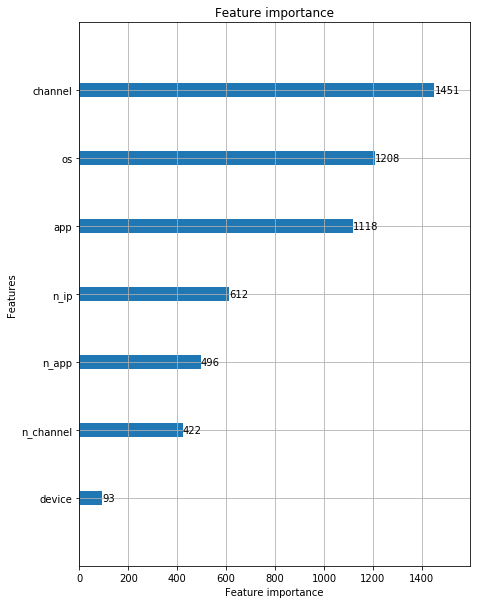

In [88]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [89]:
pred = lgb_model.predict(valid.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [90]:
pred.shape

(62945820,)

In [91]:
valid.loc[:, 'pred'] = pred

In [92]:
valid.head()

,app,device,os,channel,is_attributed,n_ip,n_app,n_channel,pred
59633310,23,1,13,153,0,1743,43345,89381,0.012839
59633311,13,1,16,477,0,144,65205,70320,0.049347
59633312,12,1,13,259,0,79,300168,70588,0.035665
59633313,15,1,19,265,0,363,244860,53805,0.053393
59633314,6,1,18,125,0,117,28960,16542,0.007314


In [93]:
roc_auc_score(valid.loc[:, target], pred)

0.9735539784164005

In [94]:
import pickle

In [95]:
with open('../results/rolling_window.pickle', 'wb') as f:
    pickle.dump(lgb_model, f)